# Sample Final Plotly Graphics

In [1]:
# Packages
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np
import pickle
import optuna
import plotly.graph_objs as go

c:\Users\iliu\AppData\Local\miniforge3\envs\mcbroken-forecasting\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
# Read excel in ../Data/Clean_McBroken_Daily.xlsx
df = pd.read_excel('../Data/Clean_McBroken_Daily.xlsx')
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2020-10-25,354.0,6818.0,5.192138,221250.0,False,True
1,2020-10-26,373.0,6844.0,5.450029,233125.0,False,True
2,2020-10-27,427.0,7488.0,5.702457,266875.0,False,True
3,2020-10-28,391.0,8294.0,4.714251,244375.0,False,True
4,2020-10-29,374.0,7461.0,5.012733,233750.0,False,True
...,...,...,...,...,...,...,...
1577,2025-02-18,1359.0,11832.0,11.485801,849375.0,False,False
1578,2025-02-19,1190.0,11835.0,10.054922,743750.0,False,False
1579,2025-02-20,1207.0,11990.0,10.066722,754375.0,False,False
1580,2025-02-21,1110.0,11907.0,9.322247,693750.0,False,False


In [3]:
# Limit to most recent 30 days for display
df = df.sort_values('Date', ascending=True).tail(30).reset_index(drop=True)
df

,Date,Broken Machines,Total Machines,Percent Broken,Revenue Losses,Outlier,Train
0,2025-01-24,1377.0,13395.0,10.279955,860625.0,False,False
1,2025-01-25,1371.0,13277.0,10.326128,856875.0,False,False
2,2025-01-26,1553.0,13446.0,11.549903,970625.0,False,False
3,2025-01-27,1660.0,13135.0,12.637990,1037500.0,False,False
4,2025-01-28,1507.0,12966.0,11.622706,941875.0,False,False
5,2025-01-29,1375.0,12984.0,10.589957,859375.0,False,False
6,2025-01-30,1302.0,12797.0,10.174260,813750.0,False,False
7,2025-01-31,1097.0,11466.0,9.567417,685625.0,False,False
8,2025-02-01,1142.0,11757.0,9.713362,713750.0,False,False
9,2025-02-02,1292.0,11835.0,10.916772,807500.0,False,False


## Prophet

In [4]:
# Load model from ../Forecasts/Models/Prophet.pkl
with open('../Forecasts/Models/Prophet.pkl', 'rb') as f:
    m = pickle.load(f)

In [5]:
# Retrieve outlier_cols
outlier_cols = list(m.extra_regressors.keys())
outlier_cols

['Outlier_2020-12-14 00:00:00',
 'Outlier_2021-07-07 00:00:00',
 'Outlier_2021-07-08 00:00:00',
 'Outlier_2021-07-09 00:00:00',
 'Outlier_2021-07-10 00:00:00',
 'Outlier_2021-07-11 00:00:00',
 'Outlier_2021-07-12 00:00:00',
 'Outlier_2021-07-13 00:00:00',
 'Outlier_2021-07-14 00:00:00',
 'Outlier_2021-07-22 00:00:00',
 'Outlier_2021-08-04 00:00:00',
 'Outlier_2021-10-01 00:00:00',
 'Outlier_2021-10-06 00:00:00',
 'Outlier_2021-12-07 00:00:00',
 'Outlier_2021-12-22 00:00:00',
 'Outlier_2022-07-08 00:00:00',
 'Outlier_2022-08-19 00:00:00',
 'Outlier_2022-09-09 00:00:00',
 'Outlier_2022-09-28 00:00:00',
 'Outlier_2022-10-12 00:00:00',
 'Outlier_2022-10-13 00:00:00',
 'Outlier_2022-10-14 00:00:00',
 'Outlier_2022-10-15 00:00:00',
 'Outlier_2022-10-16 00:00:00',
 'Outlier_2022-10-17 00:00:00',
 'Outlier_2022-10-18 00:00:00',
 'Outlier_2022-10-19 00:00:00',
 'Outlier_2022-10-20 00:00:00',
 'Outlier_2022-10-21 00:00:00',
 'Outlier_2022-10-22 00:00:00',
 'Outlier_2022-10-23 00:00:00',
 'Outlie

C:\Users\iliu\AppData\Local\Temp\ipykernel_16424\1211086000.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\iliu\AppData\Local\Temp\ipykernel_16424\1211086000.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  future[col] = [0] * len(future)
C:\Users\iliu\AppData\Local\Temp\ipykernel_16424\1211086000.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

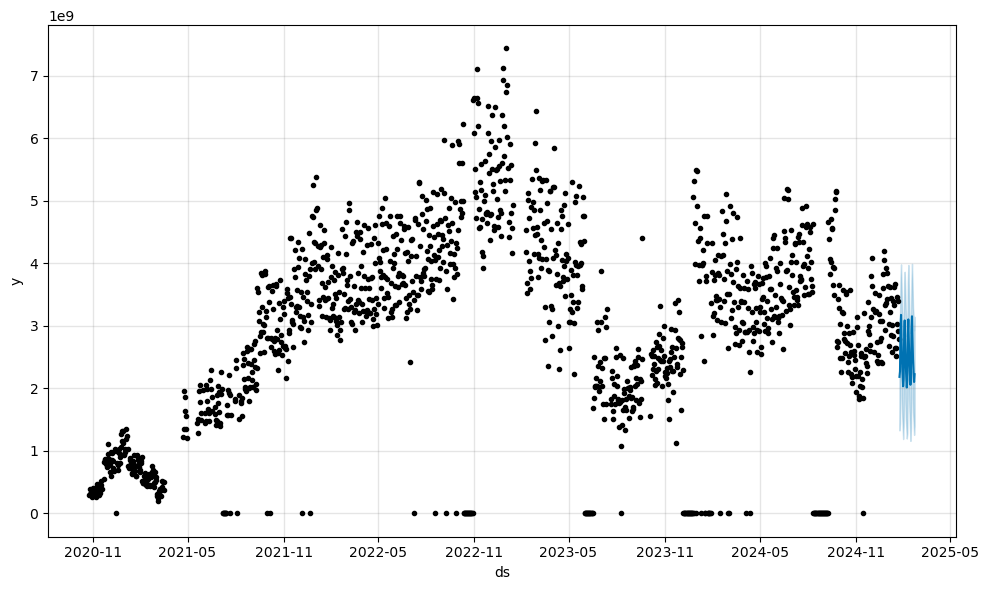

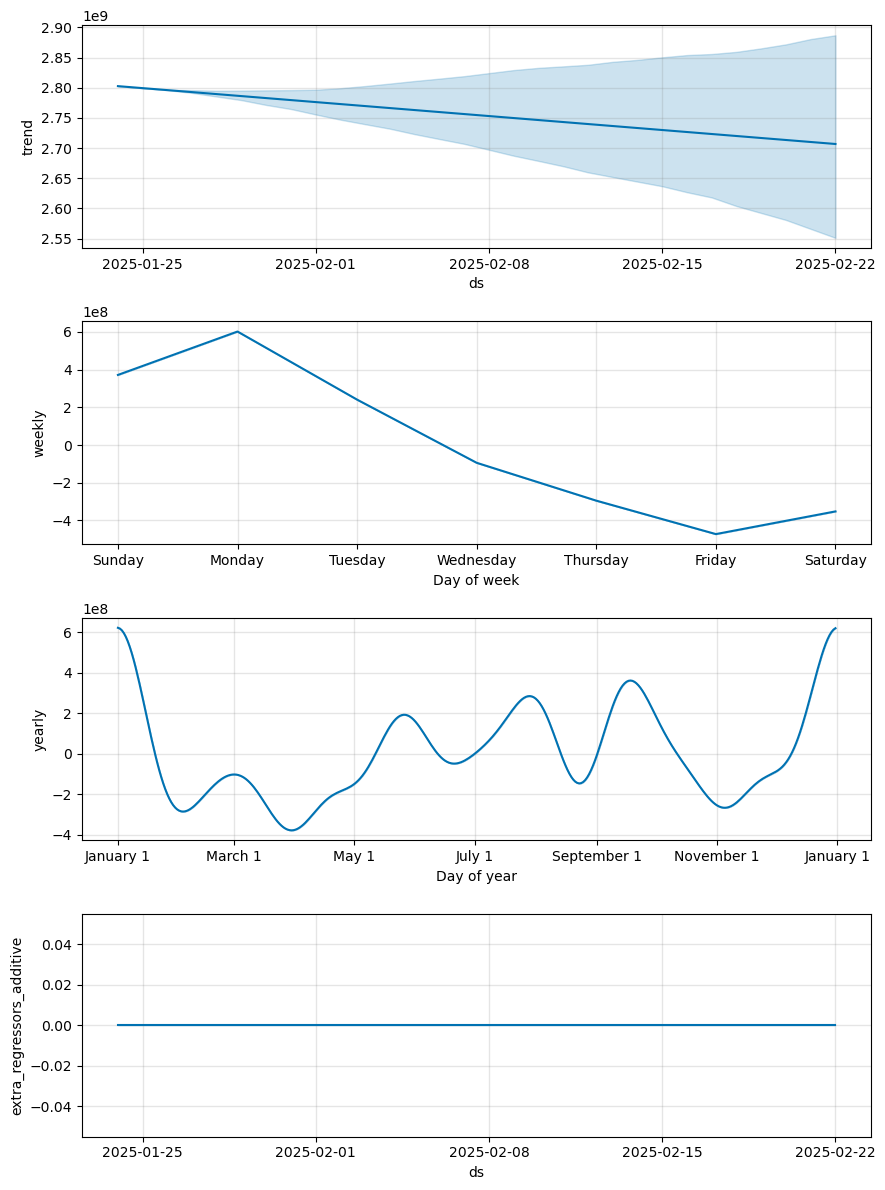

In [6]:
# Predictions
future = m.make_future_dataframe(periods=30).tail(30)

for col in outlier_cols:
    future[col] = [0] * len(future)

forecast = m.predict(future)

fig1 = m.plot(forecast)

fig2 = m.plot_components(forecast)

In [7]:
# Undo-Box-Cox

# Load lam from ../Forecasts/Models/Prophet_lam.pkl
with open('../Forecasts/Models/Prophet_lam.pkl', 'rb') as f:
    lam = pickle.load(f)

forecast['yhat'] = inv_boxcox(forecast['yhat'], lam)
forecast['yhat_lower'] = inv_boxcox(forecast['yhat_lower'], lam)
forecast['yhat_upper'] = inv_boxcox(forecast['yhat_upper'], lam)
# Add Date column
print(forecast)
print(df['Date'].max())
forecast['Date'] = [df['Date'].max() + pd.Timedelta(days=i) for i in range(1, 31)]
forecast

           ds         trend     yhat_lower    yhat_upper   trend_lower  \
0  2025-01-24  2.802628e+09  564853.910206  9.412526e+05  2.802628e+09   
1  2025-01-25  2.799324e+09  593427.884537  9.533725e+05  2.799324e+09   
2  2025-01-26  2.796019e+09  763694.647578  1.074133e+06  2.796019e+09   
3  2025-01-27  2.792715e+09  804573.553173  1.111855e+06  2.791436e+09   
4  2025-01-28  2.789410e+09  720889.677389  1.056536e+06  2.785373e+09   
5  2025-01-29  2.786106e+09  639101.743828  9.791776e+05  2.779394e+09   
6  2025-01-30  2.782801e+09  581683.588293  9.447613e+05  2.771404e+09   
7  2025-01-31  2.779497e+09  528190.563899  9.064630e+05  2.764656e+09   
8  2025-02-01  2.776193e+09  583721.647087  9.272314e+05  2.755612e+09   
9  2025-02-02  2.772888e+09  734919.811636  1.062024e+06  2.747048e+09   
10 2025-02-03  2.769584e+09  805521.959853  1.091544e+06  2.739506e+09   
11 2025-02-04  2.766279e+09  699244.452476  1.041614e+06  2.732061e+09   
12 2025-02-05  2.762975e+09  620802.40

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Outlier_2020-12-14 00:00:00,Outlier_2020-12-14 00:00:00_lower,Outlier_2020-12-14 00:00:00_upper,Outlier_2021-07-07 00:00:00,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Date
0,2025-01-24,2.802628e+09,564853.910206,9.412526e+05,2.802628e+09,2.802628e+09,0.0,0.0,0.0,0.0,...,-4.725061e+08,-4.725061e+08,-1.460493e+08,-1.460493e+08,-1.460493e+08,0.0,0.0,0.0,767839.374136,2025-02-23
1,2025-01-25,2.799324e+09,593427.884537,9.533725e+05,2.799324e+09,2.799324e+09,0.0,0.0,0.0,0.0,...,-3.522105e+08,-3.522105e+08,-1.736883e+08,-1.736883e+08,-1.736883e+08,0.0,0.0,0.0,787049.767302,2025-02-24
2,2025-01-26,2.796019e+09,763694.647578,1.074133e+06,2.796019e+09,2.796479e+09,0.0,0.0,0.0,0.0,...,3.716918e+08,3.716918e+08,-1.981866e+08,-1.981866e+08,-1.981866e+08,0.0,0.0,0.0,927888.894084,2025-02-25
3,2025-01-27,2.792715e+09,804573.553173,1.111855e+06,2.791436e+09,2.795950e+09,0.0,0.0,0.0,0.0,...,6.018178e+08,6.018178e+08,-2.194974e+08,-2.194974e+08,-2.194974e+08,0.0,0.0,0.0,966955.414518,2025-02-26
4,2025-01-28,2.789410e+09,720889.677389,1.056536e+06,2.785373e+09,2.795028e+09,0.0,0.0,0.0,0.0,...,2.406781e+08,2.406781e+08,-2.376219e+08,-2.376219e+08,-2.376219e+08,0.0,0.0,0.0,893391.151747,2025-02-27
5,2025-01-29,2.786106e+09,639101.743828,9.791776e+05,2.779394e+09,2.795289e+09,0.0,0.0,0.0,0.0,...,-9.435845e+07,-9.435845e+07,-2.526066e+08,-2.526066e+08,-2.526066e+08,0.0,0.0,0.0,821928.048240,2025-02-28
6,2025-01-30,2.782801e+09,581683.588293,9.447613e+05,2.771404e+09,2.795664e+09,0.0,0.0,0.0,0.0,...,-2.951128e+08,-2.951128e+08,-2.645386e+08,-2.645386e+08,-2.645386e+08,0.0,0.0,0.0,776277.300234,2025-03-01
7,2025-01-31,2.779497e+09,528190.563899,9.064630e+05,2.764656e+09,2.796053e+09,0.0,0.0,0.0,0.0,...,-4.725061e+08,-4.725061e+08,-2.735413e+08,-2.735413e+08,-2.735413e+08,0.0,0.0,0.0,734758.465809,2025-03-02
8,2025-02-01,2.776193e+09,583721.647087,9.272314e+05,2.755612e+09,2.796639e+09,0.0,0.0,0.0,0.0,...,-3.522105e+08,-3.522105e+08,-2.797689e+08,-2.797689e+08,-2.797689e+08,0.0,0.0,0.0,759172.723686,2025-03-03
9,2025-02-02,2.772888e+09,734919.811636,1.062024e+06,2.747048e+09,2.799204e+09,0.0,0.0,0.0,0.0,...,3.716918e+08,3.716918e+08,-2.834017e+08,-2.834017e+08,-2.834017e+08,0.0,0.0,0.0,906875.796709,2025-03-04


In [8]:
# Plot the actual data
actual_trace = go.Scatter(
    x=df['Date'],
    y=df['Revenue Losses'],
    mode='lines+markers',
    name='Actual Revenue Losses',
    hoverinfo='text',
    #hovertemplate="%{x|%a, %b %d, %Y}<br>Actual Revenue Losses<br>$%{y:,.0f}<extra></extra>",
    hovertext=[f"{date.strftime('%a, %b %d, %Y')}<br>Actual Revenue Losses<br>${revenue:,.0f}" for date, revenue in zip(df['Date'], df['Revenue Losses'])],
    line=dict(),
    legendrank=1
)

# Plot the forecast
forecast_trace = go.Scatter(
    x=forecast['Date'],
    y=forecast['yhat'],
    mode='lines+markers',
    name='Forecast',
    hoverinfo='text',
    #hovertemplate="%{x|%a, %b %d, %Y}<br>Forecast<br>$%{y:,.0f}<extra></extra>",
    hovertext=[f"{date.strftime('%a, %b %d, %Y')}<br>Forecast<br>${revenue:,.0f}" for date, revenue in zip(forecast['Date'], forecast['yhat'])],
    line=dict(dash='solid'),
    legendrank=2
)

# Plot the prediction interval as a shaded region
interval_trace = go.Scatter(
    x=forecast['Date'].tolist() + forecast['Date'][::-1].tolist(),
    y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0, 100, 80, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Prediction Interval',
    hoverinfo='skip',
    #hoverinfo='text',
    #hovertext=[f"{date.strftime('%a, %b %d, %Y')}<br>95% Prediction Interval<br>(${lower:,.0f}, ${upper:,.0f})" for date, lower, upper in zip(forecast['Date'], forecast['yhat_lower'], forecast['yhat_upper'])],
    legendrank=3
)

# Create the figure
fig = go.Figure(data=[actual_trace, interval_trace, forecast_trace])

# Update layout for elegance
fig.update_layout(
    title='Revenue Losses and Forecast',
    template='none',
    hovermode='x unified',
    legend=dict(
        orientation='h',  # Horizontal
        x=0.5,            # Centered
        xanchor='center', # Centered
        y=-0.2,           # Below the plot area
        yanchor='top',
        traceorder='normal'
    ),
)

# Update y-axis for custom scaling
fig.update_yaxes(
    tickprefix="$",
    tickformat=".2s",  # Use "M" for millions and "K" for thousands
    tickfont=dict(size=12)
)

# Update x-axis for date format without day of the week
fig.update_xaxes(
    tickformat="%b %d, %Y",  # Month, day, and year (no day of the week)
    tickmode='auto',
    tickfont=dict(size=12)
)

fig.show()


